In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
from torch.autograd import grad as torch_grad

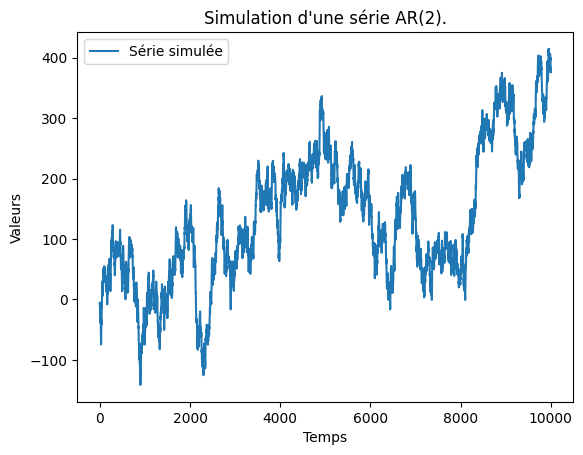

In [71]:
def data_simulation(phi1=0.8, phi2=-0.2, amplitude=1, frequency= 0.03, sigma= 2, n=300):

    amplitude = 1.0
    frequency = 0.03

    white_noise = np.random.normal(size=n)*sigma

    y_minus_1 = 0.0
    y_minus_2 = 0.0
    tren=0.2
    y = []
    for t in range(n):
        trend = tren * t if t < 200 else tren * 200  # Tendance linéaire

        seasonality = amplitude * np.sin(2 * np.pi * frequency * t)

        ar2_component = phi1 * y_minus_1 + phi2 * y_minus_2

        if 400 <= t < 500:
            trend -= 0.1 * (t - 400)
        if t==499:
            tren=0.15

        y_t = seasonality + ar2_component + white_noise[t]
        y.append(y_t)

        y_minus_2 = y_minus_1
        y_minus_1 = y_t
    return np.array(y)
y = data_simulation(phi1=1.3, phi2=-0.3, sigma=4, n= 10000)

def simple_plot(y):
    plt.plot(y, label='Série simulée')
    plt.title('Simulation d\'une série AR(2).')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.legend()
    plt.show()
simple_plot(y)


In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.ts_dim = ts_dim
        self.condition = condition
        self.hidden = 128
        
        self.block = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
           
        )
        self.block_cnn = nn.Sequential(
            nn.Conv1d(self.hidden,self.hidden, kernel_size=3, dilation=2, padding=2),
            nn.LeakyReLU(inplace=True),
        )
        self.block_shift = nn.Sequential(
            nn.Conv1d(self.hidden,10, kernel_size=3, dilation=2, padding=2),
            nn.LeakyReLU(inplace=True),
            
            nn.Flatten(start_dim=1),
            nn.Linear(10*self.latent_dim,256),
            nn.LeakyReLU(inplace=True),
        )
        self.noise_to_latent = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.hidden, kernel_size=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(self.hidden,self.hidden, kernel_size=5, dilation=2, padding=4),
            nn.LeakyReLU(inplace=True),
        )
        self.latent_to_output = nn.Sequential(
            nn.Linear(256, self.ts_dim-self.condition),
        )

    def forward(self, input_data):
        x = self.noise_to_latent(input_data)
        x_block = self.block_cnn(x)
        x = x_block +x
        x_block = self.block_cnn(x)
        x = x_block +x
        x_block = self.block_cnn(x)
        x = x_block +x
        x = self.block_shift(x)
        x_block = self.block(x)
        x = x_block + x #torch.cat([x, x_block], 1)
        x_block = self.block(x)
        x = x_block + x #torch.cat([x, x_block], 1)
        x_block = self.block(x)
        x = x_block + x #torch.cat([x, x_block], 1)
        x = self.latent_to_output(x)
        return x[:,None,:]


class Discriminator(nn.Module):
    def __init__(self, ts_dim):
        super(Discriminator,self).__init__()

        self.ts_dim = ts_dim
        self.ts_to_feature = nn.Sequential(
            nn.Linear(self.ts_dim, 512),
            nn.LeakyReLU(inplace=True),
        )
        self.block = nn.Sequential(    
            nn.Linear(512, 512),
            nn.LeakyReLU(inplace=True),
        )
        self.to_score = nn.Sequential(
            nn.Linear(512, 1)
        )

            #nn.Sigmoid() #todo add acitivation or not, whole batch has same activiation?

        

    def forward(self, input_data):

        x = self.ts_to_feature(input_data)
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x_block = self.block(x)
        x = x + x_block
        x = self.to_score(x)
        
        return x

In [207]:
class Data(object):
    def __init__(self, data, n):
        self.data= data
        self.n = n
        self.augment_data= np.array(self.moving_window(self.data, self.n))

    def moving_window(self,x, length):
        return [x[i: i+ length] for i in range(0,(len(x)+1)-length, 10)]
    
    def get_samples(self, G, latent_dim, ts_dim, batch_size, conditional, use_cuda, data):
        noise = torch.randn((batch_size,1,latent_dim))
        idx = np.random.randint(self.augment_data.shape[0], size=batch_size)

        real_samples = self.augment_data[idx, :]
        
        real_samples = np.expand_dims(real_samples, axis=1)
        real_samples = torch.from_numpy(real_samples)
        
        if conditional>0:
            noise[:,:,:conditional] = real_samples[:,:,:conditional]

        if use_cuda:
            noise = noise.cuda()
            real_samples = real_samples.cuda()
            G.cuda()

        y = G(noise)
        
        y = y.float()
        y = torch.cat((real_samples[:,:,:conditional].float().cpu(),y.float().cpu()), dim=2)
        
        if use_cuda:
            y = y.cuda()
        return y.float(), real_samples.float()

In [202]:
def plt_progress(real, fake, epoch, path):
    real = np.squeeze(real)
    fake = np.squeeze(fake)
    
    fig, ax = plt.subplots(2,2,figsize=(10, 10))
    ax = ax.flatten()
    fig.suptitle('Data generation, iter:' +str(epoch))
    for i in range(ax.shape[0]):
        ax[i].plot(real[i], color='red', label='Real', alpha =0.7)
        ax[i].plot(fake[i], color='blue', label='Fake', alpha =0.7)
        ax[i].legend()

    plt.savefig(path+'/Iteration_' + str(epoch) + '.png', bbox_inches='tight', pad_inches=0.5)
    plt.clf()

In [206]:
class gen_model():
    def __init__(self, data ,generator, critic, gen_optimizer, critic_optimizer, batch_size, path, ts_dim, latent_dim, D_scheduler, G_scheduler, gp_weight=10,critic_iter=5, n_eval=20, use_cuda=False):
        self.G = generator
        self.D = critic
        self.G_opt = gen_optimizer
        self.D_opt = critic_optimizer
        self.G_scheduler = G_scheduler
        self.D_scheduler = D_scheduler
        self.batch_size = batch_size
        self.scorepath = path
        self.gp_weight = gp_weight
        self.critic_iter = critic_iter
        self.n_eval = n_eval
        self.use_cuda = use_cuda
        self.conditional = 3
        self.ts_dim = ts_dim
        self.data = Data(data,ts_dim)
        self.y = data


        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

        
        self.latent_dim = latent_dim
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': [], 'LR_G': [], 'LR_D':[]}

    def train_model(self, epochs):
        for epoch in trange(epochs):
            for i in range(self.critic_iter):
                fake_batch, real_batch = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
            for i in range(self.critic_iter):
                # train the critic
                fake_batch, real_batch = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
                if self.use_cuda:
                    real_batch = real_batch.cuda()
                    fake_batch = fake_batch.cuda()
                    self.D.cuda()
                    self.G.cuda()
                
                d_real = self.D(real_batch)
                d_fake = self.D(fake_batch)

                grad_penalty, grad_norm_ = self._grad_penalty(real_batch, fake_batch)
                # backprop with minimizing the difference between distribution fake and distribution real
                self.D_opt.zero_grad()
                 
                d_loss = d_fake.mean() - d_real.mean() + grad_penalty.to(torch.float32)
                d_loss.backward()
                self.D_opt.step()
                

                if i == self.critic_iter-1:
                    self.D_scheduler.step()
                    self.losses['LR_D'].append(self.D_scheduler.get_lr())
                    self.losses['D'].append(float(d_loss))
                    self.losses['GP'].append(grad_penalty.item())
                    self.losses['gradient_norm'].append(float(grad_norm_))
            
            self.G_opt.zero_grad()
            fake_batch_critic, real_batch_critic = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
            if self.use_cuda:
                real_batch_critic = real_batch_critic.cuda()
                fake_batch_critic = fake_batch_critic.cuda()
                self.D.cuda()
                self.G.cuda()
            # feed-forward
            d_critic_fake = self.D(fake_batch_critic)

            g_loss =  - d_critic_fake.mean()  # d_critic_real.mean()
            # backprop
            g_loss.backward()
            self.G_opt.step()
            self.G_scheduler.step()
            self.losses['LR_G'].append(self.G_scheduler.get_lr())

            # save the loss of feed forward
            self.losses['G'].append(g_loss.item())  # outputs tensor with single value
            if (epoch + 1) % self.n_eval == 0:
                if (epoch+1) % 1000 ==0:
                    plot_num = plot_num+1
                oui=3
            if (epoch + 1) % (10*self.n_eval) == 0:
                fake_lines, real_lines = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
                self.real_lines = np.squeeze(real_lines.cpu().data.numpy())
                self.fake_lines = np.squeeze(fake_lines.cpu().data.numpy())
                plt_progress(self.fake_lines, self.real_lines,epoch, "./logs")

            fake_lines, real_lines = self.data.get_samples(G=self.G, latent_dim=self.latent_dim, batch_size=self.batch_size, ts_dim=self.ts_dim,conditional=self.conditional,data= self.y, use_cuda=self.use_cuda)
            self.real_lines = np.squeeze(real_lines.cpu().data.numpy())
            self.fake_lines = np.squeeze(fake_lines.cpu().data.numpy())
            if (epoch + 1) % 500 ==0:
                name = 'CWGAN-GP_model_Dense3_concat_fx'
                #torch.save(self.G.state_dict(), self.scorepath + '/gen_' + name + '.pt')
                #torch.save(self.D.state_dict(), self.scorepath + '/dis_' + name + '.pt')    



    def _grad_penalty(self, real_data, gen_data):
        batch_size = real_data.size()[0]
        t = torch.rand((batch_size, 1, 1), requires_grad=True)
        t = t.expand_as(real_data)

        if self.use_cuda:
            t = t.cuda()

        # mixed sample from real and fake; make approx of the 'true' gradient norm
        interpol = t * real_data.data + (1-t) * gen_data.data

        if self.use_cuda:
            interpol = interpol.cuda()
        
        prob_interpol = self.D(interpol)
        torch.autograd.set_detect_anomaly(True)
        gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                               grad_outputs=torch.ones(prob_interpol.size()).cuda() if self.use_cuda else torch.ones(
                                   prob_interpol.size()), create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(batch_size, -1)
        #grad_norm = torch.norm(gradients, dim=1).mean()
        #self.losses['gradient_norm'].append(grad_norm.item())

        # add epsilon for stability
        eps = 1e-10
        gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
        #gradients = gradients.cpu()
        # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
        return self.gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if self.use_cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()

latent_dim = 10
ts_dim = 23
conditional = 3

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
lr_a = 1e-4
lr_b = 1e-4
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = 1e-4, max_lr= 8e-4, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = 1e-4, max_lr= 6e-4, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 5000
batch_size = 128
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, use_cuda=use_cuda)
train.train_model(epochs=500)

True


  0%|          | 0/500 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 500/500 [06:01<00:00,  1.38it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

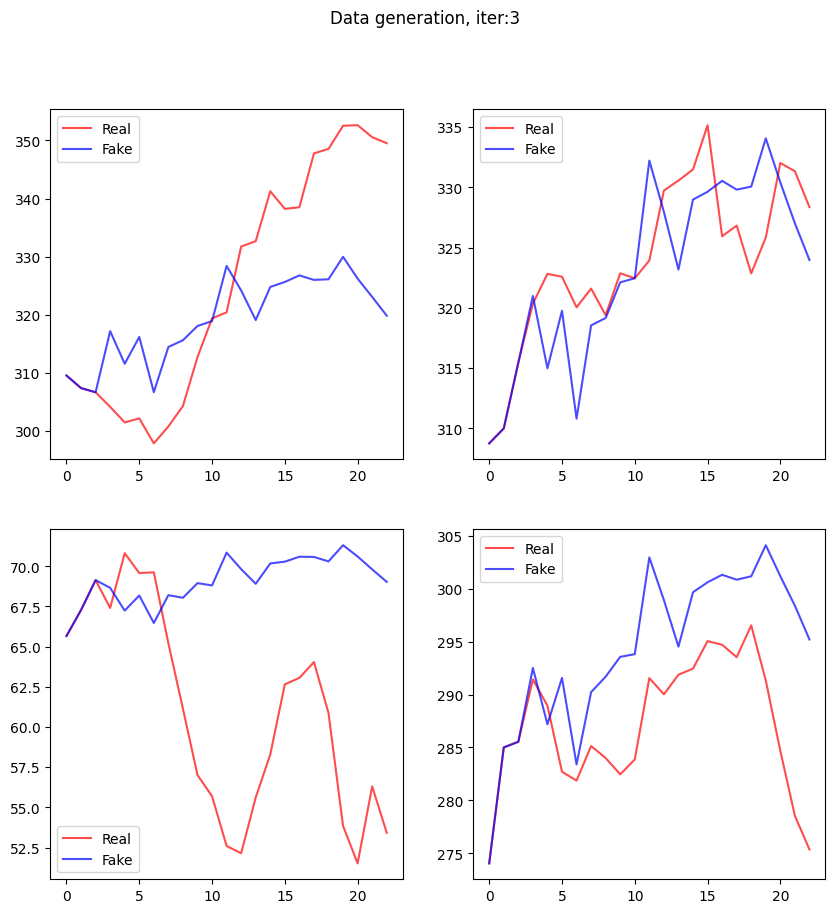

In [209]:
real = np.squeeze(train.real_lines)
fake = np.squeeze(train.fake_lines)

fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax = ax.flatten()
fig.suptitle('Data generation, iter:' +str(3))
for i in range(ax.shape[0]):
    ax[i].plot(real[i], color='red', label='Real', alpha =0.7)
    ax[i].plot(fake[i], color='blue', label='Fake', alpha =0.7)
    ax[i].legend()

plt.show()